# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [142]:
import pandas as pd
import numpy as np
import itertools
from sklearn import tree
import time

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight") # styling your charts
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter

# pre-processing
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator
from imblearn.over_sampling import SMOTE
from collections import Counter

# modeling
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn import tree

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, plot_confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, RocCurveDisplay


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("All modules loaded")

All modules loaded


In [54]:
df = pd.read_csv(r'C:\Users\NemindaM19\Google Drive\AI and ML\Module 17\data\bank-additional-full.csv', sep = ';')

In [55]:
df.shape

(41188, 21)

In [56]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [57]:
for col in df.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(df[col].value_counts()) # value count for entire columns 

----------------------------------------age---------------------------------------- - 

31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: age, Length: 78, dtype: int64

----------------------------------------job---------------------------------------- - 

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

----------------------------------------marital---------------------------------------- - 

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

----------------------------------------education---------------------------------------- - 

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

----------------------------------------default---------------------------------------- - 

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

----------------------------------------housing---------------------------------------- - 

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

----------------------------------------loan---------------------------------------- - 

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

----------------------------------------contact---------------------------------------- - 

cellular     26144
telephone    15044
Name: contact, dtype: int64

----------------------------------------month---------------------------------------- - 

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

----------------------------------------day_of_week---------------------------------------- - 

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

----------------------------------------duration---------------------------------------- - 

90      170
85      170
136     168
73      167
124     164
       ... 
1569      1
1053      1
1263      1
1169      1
1868      1
Name: duration, Length: 1544, dtype: int64

----------------------------------------campaign---------------------------------------- - 

1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
32        4
33        4
34        3
42        2
40        2
43        2
56        1
39        1
41        1
37        1
Name: campaign, dtype: int64

----------------------------------------pdays---------------------------------------- - 

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: pdays, dtype: int64

----------------------------------------previous---------------------------------------- - 

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

----------------------------------------poutcome---------------------------------------- - 

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

----------------------------------------emp.var.rate---------------------------------------- - 

 1.4    16234
-1.8     9184
 1.1     7763
-0.1     3683
-2.9     1663
-3.4     1071
-1.7      773
-1.1      635
-3.0      172
-0.2       10
Name: emp.var.rate, dtype: int64

----------------------------------------cons.price.idx---------------------------------------- - 

93.994    7763
93.918    6685
92.893    5794
93.444    5175
94.465    4374
93.200    3616
93.075    2458
92.201     770
92.963     715
92.431     447
92.649     357
94.215     311
94.199     303
92.843     282
92.379     267
93.369     264
94.027     233
94.055     229
93.876     212
94.601     204
92.469     178
93.749     174
92.713     172
94.767     128
93.798      67
92.756      10
Name: cons.price.idx, dtype: int64

----------------------------------------cons.conf.idx---------------------------------------- - 

-36.4    7763
-42.7    6685
-46.2    5794
-36.1    5175
-41.8    4374
-42.0    3616
-47.1    2458
-31.4     770
-40.8     715
-26.9     447
-30.1     357
-40.3     311
-37.5     303
-50.0     282
-29.8     267
-34.8     264
-38.3     233
-39.8     229
-40.0     212
-49.5     204
-33.6     178
-34.6     174
-33.0     172
-50.8     128
-40.4      67
-45.9      10
Name: cons.conf.idx, dtype: int64

----------------------------------------euribor3m---------------------------------------- - 

4.857    2868
4.962    2613
4.963    2487
4.961    1902
4.856    1210
         ... 
3.853       1
3.901       1
0.969       1
0.956       1
3.669       1
Name: euribor3m, Length: 316, dtype: int64

----------------------------------------nr.employed---------------------------------------- - 

5228.1    16234
5099.1     8534
5191.0     7763
5195.8     3683
5076.2     1663
5017.5     1071
4991.6      773
5008.7      650
4963.6      635
5023.5      172
5176.3       10
Name: nr.employed, dtype: int64

----------------------------------------y---------------------------------------- - 

no     36548
yes     4640
Name: y, dtype: int64

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [59]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [60]:
df.duplicated().sum()

12

In [61]:
df.drop_duplicates(inplace = True)

In [62]:
df.shape

(41176, 21)

### Understanding the Data

In [63]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [64]:
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10419,24921,12164,32577,21571,33938,26135,13767,8618,35551,36537


#### Understanding the Numerical Data

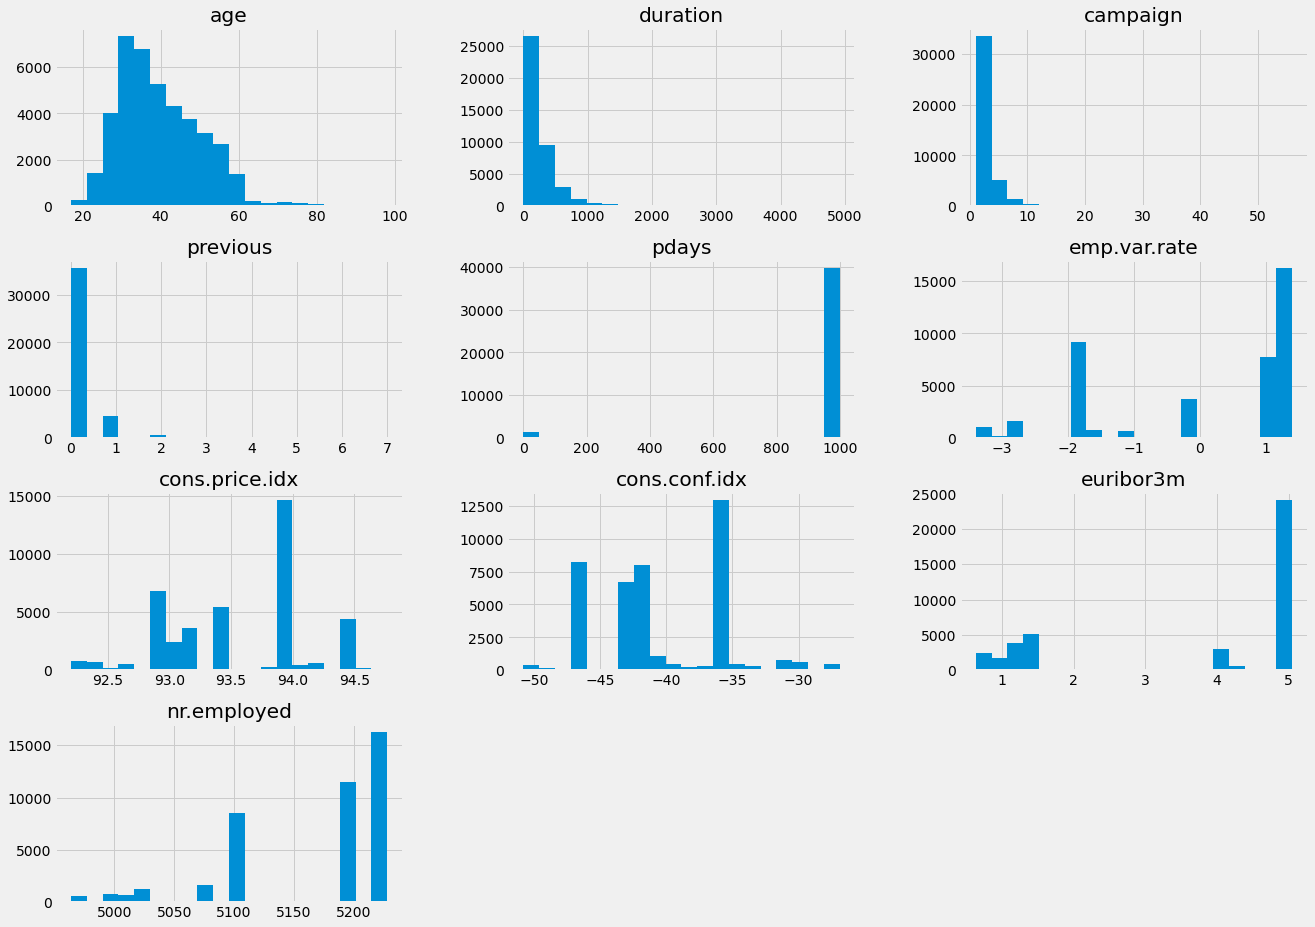

In [65]:
df[['age','duration','campaign','previous','pdays',
    'emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']].hist(bins=20, figsize=(20,15))
plt.show()

#### Understanding the Catergorical Data

In [66]:
category_features = df.select_dtypes(include=['object', 'bool']).columns.values

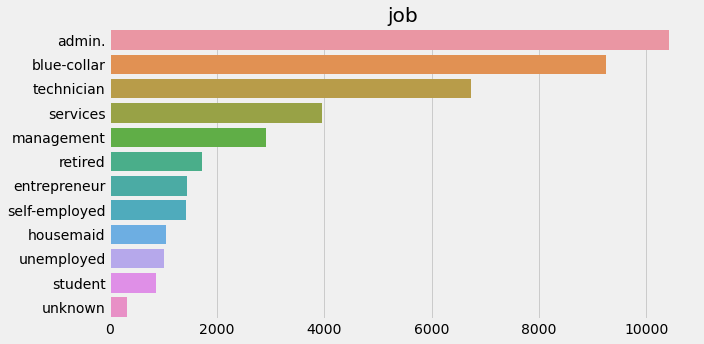

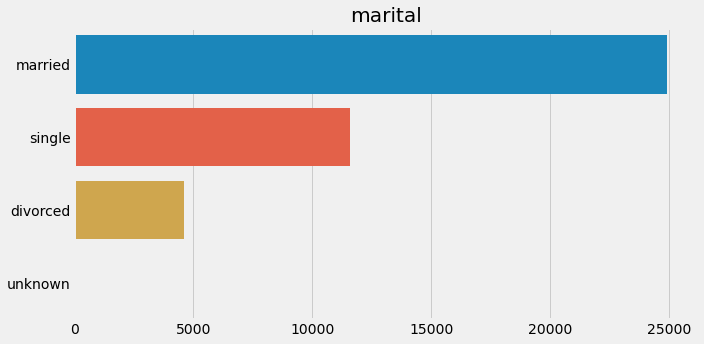

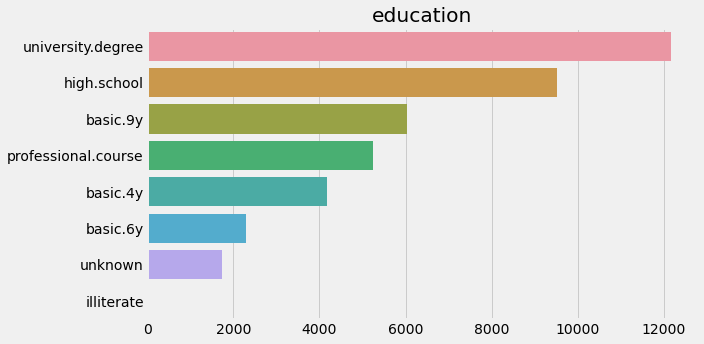

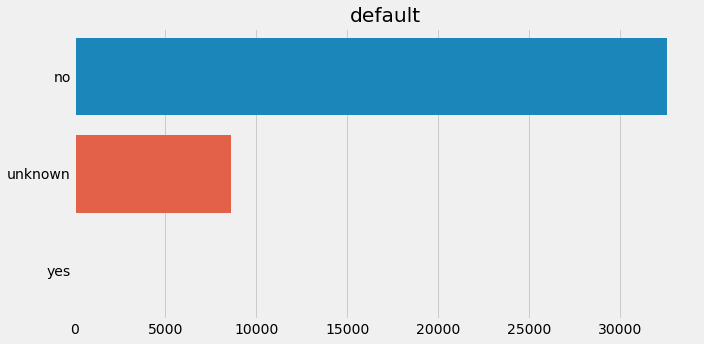

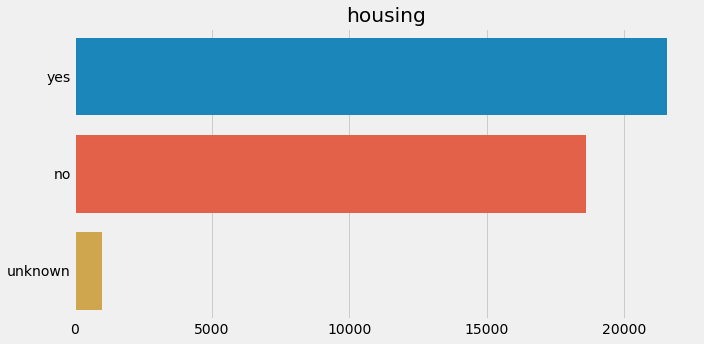

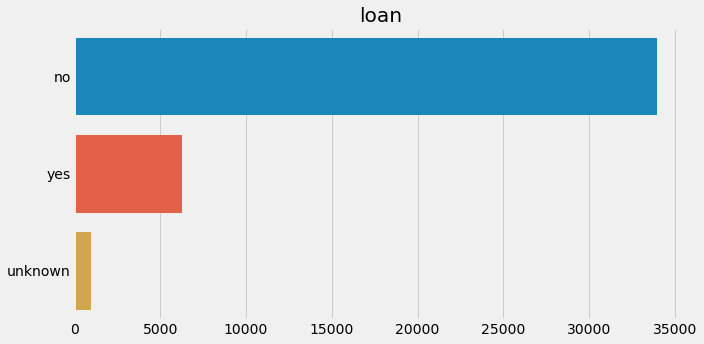

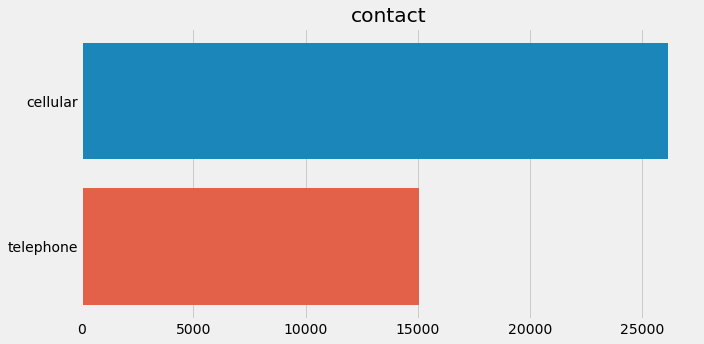

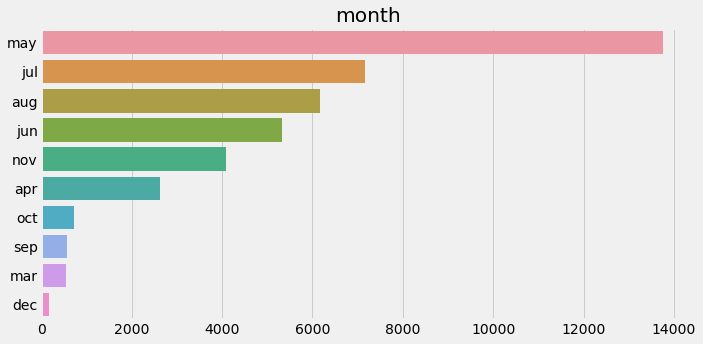

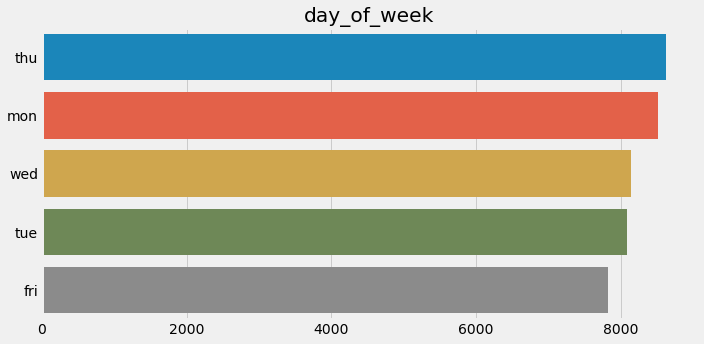

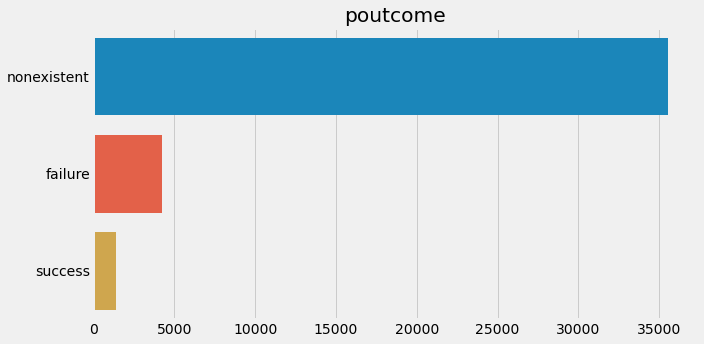

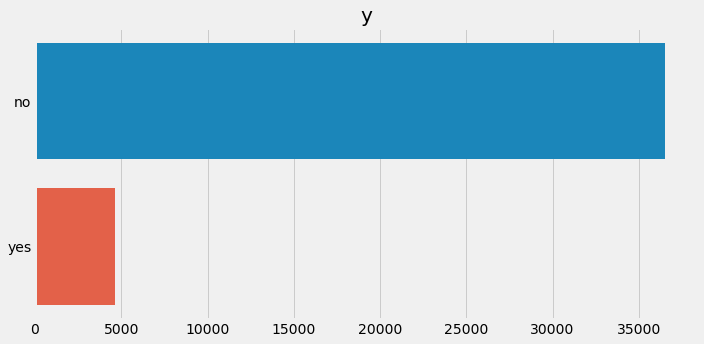

In [67]:
for col in category_features:
    plt.figure(figsize=(10,5))    
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index, data=df)    
    plt.title(col)    
    plt.tight_layout()

In [68]:
df['y'].value_counts(normalize=True)

no     0.887337
yes    0.112663
Name: y, dtype: float64

In [69]:
df['y'] = df['y'].replace({"no":0, "yes":1})

In [70]:
df['y'].value_counts()

0    36537
1     4639
Name: y, dtype: int64

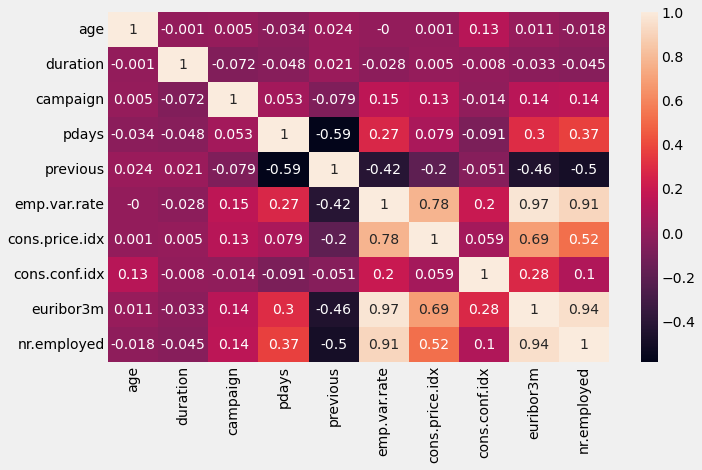

In [71]:
corr = df.drop('y', axis = 1).corr().round(3)
plt.figure(figsize = (10, 6))
sns.heatmap(corr, annot = True);

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

See below for engineering features

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [72]:
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=21)

print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", y_train.shape)
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

X_train dataset:  (32940, 20)
y_train dataset:  (32940,)
X_test dataset:  (8236, 20)
y_test dataset:  (8236,)


In [73]:
X_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
20822,35,admin.,married,university.degree,unknown,no,no,cellular,aug,wed,181,5,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
32904,32,entrepreneur,married,high.school,no,yes,no,cellular,may,mon,101,2,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1
19642,48,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,115,3,999,0,nonexistent,1.4,93.444,-36.1,4.968,5228.1
4544,44,admin.,married,basic.4y,unknown,yes,yes,telephone,may,tue,139,5,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0
38926,55,management,married,university.degree,no,yes,no,cellular,nov,wed,99,1,999,1,failure,-3.4,92.649,-30.1,0.716,5017.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16435,36,blue-collar,married,high.school,no,yes,no,cellular,jul,wed,77,11,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
8965,34,admin.,single,university.degree,no,no,no,telephone,jun,thu,128,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1
5945,37,blue-collar,married,basic.4y,no,no,no,telephone,may,tue,565,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
5328,39,admin.,married,professional.course,no,yes,no,telephone,may,fri,232,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [74]:
num_features = X_train.select_dtypes(exclude=['object']).columns.values.tolist()
cat_features = X_train.select_dtypes(exclude=['float64', 'int64']).columns.values.tolist()

print(num_features)
print(cat_features)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [75]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_features),
    ('onehot', OneHotEncoder(sparse=False), cat_features)]) 
preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['age', 'duration', 'campaign', 'pdays',
                                  'previous', 'emp.var.rate', 'cons.price.idx',
                                  'cons.conf.idx', 'euribor3m',
                                  'nr.employed']),
                                ('onehot', OneHotEncoder(sparse=False),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'day_of_week', 'poutcome'])])

In [76]:
preprocessor = make_column_transformer(    
    (StandardScaler(), num_features),  # scaling on numeric features    
    (OneHotEncoder(), cat_features)  # OHE on categorical features
)

In [108]:
X_train_pre= preprocessor.fit_transform(X_train)

In [118]:
X_test_pre=preprocessor.transform(X_test)

In [109]:
column_names = (
    num_features    
    + preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)

In [110]:
preprocessor.named_transformers_

{'standardscaler': StandardScaler(), 'onehotencoder': OneHotEncoder()}

In [111]:
X_train_scaled=pd.DataFrame(X_train_pre, columns=column_names)
X_train_scaled

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,-0.480936,-0.295807,0.878782,0.194775,-0.349348,0.838493,-0.225851,0.947875,0.774283,0.845235,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.768926,-0.603426,-0.204607,0.194775,1.669868,-1.198245,-1.177590,-1.230496,-1.339139,-0.941093,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.767020,-0.549593,0.156522,0.194775,-0.349348,0.838493,-0.225851,0.947875,0.776013,0.845235,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.383033,-0.457307,0.878782,0.194775,-0.349348,0.647549,0.724160,0.883171,0.711446,0.331493,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.438996,-0.611117,-0.565737,0.194775,1.669868,-2.216614,-1.599049,2.241956,-1.675234,-2.071050,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32935,-0.384939,-0.695712,3.045560,0.194775,-0.349348,0.838493,0.592886,-0.475615,0.773130,0.845235,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
32936,-0.576932,-0.499605,-0.565737,0.194775,-0.349348,0.838493,1.537715,-0.281503,0.717210,0.845235,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
32937,-0.288943,1.180765,-0.204607,0.194775,-0.349348,0.647549,0.724160,0.883171,0.712022,0.331493,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
32938,-0.096950,-0.099700,-0.565737,0.194775,-0.349348,0.647549,0.724160,0.883171,0.712022,0.331493,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [45]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32940 entries, 0 to 32939
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            32940 non-null  float64
 1   duration                       32940 non-null  float64
 2   campaign                       32940 non-null  float64
 3   pdays                          32940 non-null  float64
 4   previous                       32940 non-null  float64
 5   emp.var.rate                   32940 non-null  float64
 6   cons.price.idx                 32940 non-null  float64
 7   cons.conf.idx                  32940 non-null  float64
 8   euribor3m                      32940 non-null  float64
 9   nr.employed                    32940 non-null  float64
 10  job_admin.                     32940 non-null  float64
 11  job_blue-collar                32940 non-null  float64
 12  job_entrepreneur               32940 non-null 

#### Balancing the data by using SMOTE

In [82]:
y_train.shape

(32940,)

In [98]:
sm=SMOTE(random_state=21)
X_train_final, y_train_final = sm.fit_resample(X_train_scaled, y_train)

In [99]:
print('Resampled dataset shape %s' % Counter(y_train_final))

Resampled dataset shape Counter({0: 29248, 1: 29248})


In [100]:
X_train_final

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,-0.480936,-0.295807,0.878782,0.194775,-0.349348,0.838493,-0.225851,0.947875,0.774283,0.845235,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.0,1.0,0.0
1,-0.768926,-0.603426,-0.204607,0.194775,1.669868,-1.198245,-1.177590,-1.230496,-1.339139,-0.941093,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,1.0,0.0,0.0
2,0.767020,-0.549593,0.156522,0.194775,-0.349348,0.838493,-0.225851,0.947875,0.776013,0.845235,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.0,0.0
3,0.383033,-0.457307,0.878782,0.194775,-0.349348,0.647549,0.724160,0.883171,0.711446,0.331493,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,1.0,0.0
4,1.438996,-0.611117,-0.565737,0.194775,1.669868,-2.216614,-1.599049,2.241956,-1.675234,-2.071050,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58491,-0.481706,0.405968,-0.511712,0.194775,-0.349348,-1.898374,-1.056679,-0.065822,-1.360642,-1.258201,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.850401,0.149599,0.0,1.0,0.0
58492,-0.624004,1.911811,-0.386334,0.194775,-0.349348,0.838493,-0.225851,0.947875,0.774860,0.845235,0.0,0.0,0.0,0.0,0.503218,0.0,0.0,0.0,0.0,0.496782,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.503218,0.496782,0.496782,0.503218,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,1.0,0.0
58493,-0.576932,0.752194,-0.565737,0.194775,-0.349348,-1.198245,-1.177590,-1.230496,-1.331068,-0.941093,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.910162,0.000000,0

In [122]:
X_test_final=pd.DataFrame(X_test_pre)

In [123]:
y_test_final=y_test

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

##### Logistic regression classifier with default parameters will be considered as a baseline model to compare

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [135]:
start_lrs = time.time()
Logistic_Regression = LogisticRegression().fit(X_train_final, y_train_final)
end_lrs = time.time()
time_lrs=end_lrs - start_lrs
print(time_lrs)

0.6145975589752197


### Problem 9: Score the Model

What is the accuracy of your model?

In [136]:
lrs_train_score=Logistic_Regression.score(X_train_final, y_train_final)
lrs_train_score

0.8847784463894968

In [137]:
lrs_test_score=Logistic_Regression.score(X_test_final, y_test_final)
lrs_test_score

0.8587906750849927

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [138]:
#KNN algorithm default parameters
start_KNNs = time.time()
KNN_model = KNeighborsClassifier().fit(X_train_final, y_train_final)
end_KNNs = time.time()
time_KNNs=end_KNNs - start_KNNs
KNNs_train_score=KNN_model.score(X_train_final, y_train_final)
KNNs_test_score=KNN_model.score(X_test_final, y_test_final)

In [139]:
#Decision Tree default parameters
start_DTs = time.time()
DT_model = DecisionTreeClassifier().fit(X_train_final, y_train_final)
end_DTs = time.time()
time_DTs=end_DTs - start_DTs
DTs_train_score=DT_model.score(X_train_final, y_train_final)
DTs_test_score=DT_model.score(X_test_final, y_test_final)

In [140]:
#SVC model default parameters
start_SVCs = time.time()
SVC_model = SVC().fit(X_train_final, y_train_final)
end_SVCs = time.time()
time_SVCs=end_SVCs - start_SVCs
SVCs_train_score=SVC_model.score(X_train_final, y_train_final)
SVCs_test_score=SVC_model.score(X_test_final, y_test_final)

In [178]:
df_simple_model={'Model': [Logistic_Regression, KNN_model, DT_model, SVC_model ],
      'Train Time (s)': [time_lrs,time_KNNs, time_DTs, time_SVCs],
      'Training Accuracy':[lrs_train_score,KNNs_train_score,DTs_train_score, SVCs_train_score],
      'Test Accuracy': [lrs_test_score, KNNs_test_score, DTs_test_score, SVCs_test_score],
     }
Comparison_df_simple=pd.DataFrame(df_simple_model).set_index('Model')
Comparison_df_simple.sort_values(by=['Train Time (s)'], axis=0, ascending=True).round(3)

,Train Time (s),Training Accuracy,Test Accuracy
Model,,,
KNeighborsClassifier(),0.024,0.942,0.850
LogisticRegression(),0.615,0.885,0.859
DecisionTreeClassifier(),0.740,1.000,0.885
SVC(),115.270,0.927,0.866


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [194]:
#Loigistic Regression algorithm with Hyperparameters to tune the GridserchCV
param_grid_lr = {'penalty': ['l1', 'l2'],'C': [0.001,0.01,0.1,1,10]}
start_lr_imp = time.time()
grid_lr_imp = GridSearchCV(LogisticRegression(), 
                       param_grid=param_grid_lr,cv=5).fit(X_train_final, y_train_final)
end_lr_imp = time.time()
time_lr_imp=end_lr_imp - start_lr_imp
print(time_lr_imp)

16.205795764923096


In [195]:
grid_lr_predic1=grid_lr_imp.predict(X_test_final)
grid_lr_predic2=grid_lr_imp.predict(X_train_final)
grid_test_lr_imp = accuracy_score(y_test_final, grid_lr_predic1)
grid_train_lr_imp = accuracy_score(y_train_final, grid_lr_predic2)
print(grid_train_lr_imp, grid_test_lr_imp )

0.8847271608315098 0.8591549295774648


In [196]:
best_params_lr_imp = grid_lr_imp.best_params_
best_params_lr_imp

{'C': 10, 'penalty': 'l2'}

In [197]:
#KNN algorithm with Hyperparameters to tune the GridserchCV
param_grid_KNN = {'n_neighbors': range(1,5)}
start_KNN_imp = time.time()
grid_KNN_imp = GridSearchCV(KNeighborsClassifier(), 
                       param_grid=param_grid_KNN,cv=5).fit(X_train_final, y_train_final)
end_KNN_imp = time.time()
time_KNN_imp=end_KNN_imp - start_KNN_imp
grid_KNN_predic1=grid_KNN_imp.predict(X_test_final)
grid_KNN_predic2=grid_KNN_imp.predict(X_train_final)
grid_test_KNN_imp = accuracy_score(y_test_final, grid_KNN_predic1)
grid_train_KNN_imp = accuracy_score(y_train_final, grid_KNN_predic2)
best_params_KNN_imp = grid_KNN_imp.best_params_
best_params_KNN_imp

{'n_neighbors': 2}

In [198]:
#Decision Tree algorithm with Hyperparameters to tune the GridserchCV
param_grid_DT = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],'criterion': ['entropy', 'gini']}
start_DT_imp = time.time()
grid_DT_imp = GridSearchCV(DecisionTreeClassifier(), 
                       param_grid=param_grid_DT,cv=5).fit(X_train_final, y_train_final)
end_DT_imp = time.time()
time_DT_imp=end_DT_imp - start_DT_imp
grid_DT_predic1=grid_DT_imp.predict(X_test_final)
grid_DT_predic2=grid_DT_imp.predict(X_train_final)
grid_test_DT_imp = accuracy_score(y_test_final, grid_DT_predic1)
grid_train_DT_imp = accuracy_score(y_train_final, grid_DT_predic2)
best_params_DT_imp = grid_DT_imp.best_params_
best_params_DT_imp

{'criterion': 'gini', 'max_depth': 15}

In [199]:
#SVC model algorithm with Hyperparameters to tune the GridserchCV
# param_grid_SVC = {'C': [1,10,100] }
# start_SVC_imp = time.time()
# grid_SVC_imp = GridSearchCV(SVC(), 
#                        param_grid=param_grid_SVC).fit(X_train_final, y_train_final)
# end_SVC_imp = time.time()
# time_SVC_imp=end_SVC_imp - start_SVC_imp
# grid_SVC_predic1=grid_SVC_imp.predict(X_test_final)
# grid_SVC_predic2=grid_SVC_imp.predict(X_train_final)
# grid_test_SVC = accuracy_score(y_test_final, grid_SVC_predic1)
# grid_train_SVC = accuracy_score(y_train_final, grid_SVC_predic2)
# best_params_SVC_imp = grid_SVC_imp.best_params_
# best_params_SVC_imp

SVC was taking along time to converge hence SVC was not included in the comparison

In [202]:
df_improved_model={'Model': [Logistic_Regression, KNN_model, DT_model],
      'Train Time (s)': [time_lr_imp,time_KNN_imp, time_DT_imp],
      'Training Accuracy':[grid_train_lr_imp,grid_train_KNN_imp,grid_train_DT_imp],
      'Test Accuracy': [grid_test_lr_imp, grid_test_KNN_imp, grid_test_DT_imp],
     }
Comparison_df_imp=pd.DataFrame(df_improved_model).set_index('Model')
Comparison_df_imp.sort_values(by=['Train Time (s)'], axis=0, ascending=True).round(3)

,Train Time (s),Training Accuracy,Test Accuracy
Model,,,
LogisticRegression(),16.206,0.885,0.859
KNeighborsClassifier(),38.706,0.999,0.877
DecisionTreeClassifier(),73.108,0.972,0.885


In [204]:
# Difference between simple method and Improved method 

Delta_df={'Model': [Logistic_Regression, KNN_model, DT_model],
      'Train Time Delta (s)': [time_lr_imp-time_lrs,time_KNN_imp-time_KNNs, time_DT_imp-time_DTs],
      'Training Accuracy Delta':[grid_train_lr_imp-lrs_train_score,grid_train_KNN_imp-KNNs_train_score,
                                 grid_train_DT_imp-DTs_train_score],
      'Test Accuracy Delta': [grid_test_lr_imp-lrs_test_score, grid_test_KNN_imp-KNNs_test_score,
                              grid_test_DT_imp-DTs_test_score],
     }
change=pd.DataFrame(Delta_df).set_index('Model')
change.sort_values(by=['Train Time Delta (s)'], axis=0, ascending=True).round(3)

,Train Time Delta (s),Training Accuracy Delta,Test Accuracy Delta
Model,,,
LogisticRegression(),15.591,-0.000,0.000
KNeighborsClassifier(),38.682,0.057,0.027
DecisionTreeClassifier(),72.368,-0.028,0.000


##### Questions